### Bayesian Prediction Model

In [1]:
import numpy as np
import scipy
import random
import urllib
import matplotlib.pyplot as plt
import json

In [2]:
random.seed(0) #set an initial seed so that we can reproduce consistently

In [3]:
def readJSONfromFile(fname):
    yelp_data = []
    with open(fname) as f:
        for line in f:
            yelp_data.append(json.loads(line))
    return yelp_data

In [4]:
Iu = readJSONfromFile('data/yelp_Iu.json')

In [5]:
Iu = Iu[0]

In [6]:
len(Iu)

721779

In [7]:
Iu['PmgqNO0-5Y3e3UoR61TD7w']

[u'4P-vTvE6cncJyUyLh73pxw',
 u'cF98fzqrMnikhXhuSz6ruQ',
 u'mlCDsdVFuZvRGrJTfQ6amw',
 u'PjQngP_7m7PA8K1WUHdXqg',
 u'Mgvs9XPJpR2Vo5D4Tb59sA',
 u'xsTagHpGvtH5WoDJJGnq7Q',
 u'j6MtKpKdqZC2wXnQetGBIQ',
 u'n3cFalLLuMyAy3Oe2dcwQw',
 u'LNsZJP6jZ11e0tDljOLPiQ',
 u'0i95sgY7pzYW9k88SOVJ8A',
 u'bkwXWFCRGra9q2lfYDTIBA',
 u'eoJfl5vG7X87QhcKb0nt5Q',
 u'cYwJA2A6I12KNkm2rtXd5g',
 u'L6-rMdUvJXGUzrNdhiNT6A',
 u'K7lWdNUhCbcnEvI0NhGewg',
 u'OF19lUVQHj8pVaSACNewWg',
 u'1t2UKl2k59iMdNhCfppLcQ',
 u'z45xS0Kc6GpiITwrpkRVdQ',
 u'n0NH0FW8NU3zfeJY3QluMQ',
 u'Ay2hfgpp8kELkwy76BRWLQ',
 u'hyyy_yFDI3CJJaG3uROGBA']

In [8]:
I = readJSONfromFile('data/yelp_restaurant_data.json')

In [9]:
I = I[0]

In [10]:
AllRest = []
for i in I:
    AllRest.append(i['business_id'])

In [11]:
AllUser = Iu.keys()

In [12]:
len(AllUser)

721779

In [13]:
len(AllRest)

48485

In [14]:
AllRestSet = set(AllRest)   #has the set of all restaurant ids

In [77]:
Lambda = 1
Alpha = 10**-5
K = 10

In [16]:
Gamma_u = dict()
Gamma_r = dict()   #Latent factor variables
for user in AllUser:
    Gamma_u[user] = np.random.rand(K)
for rest in AllRest:
    Gamma_r[rest] = np.random.rand(K)

In [18]:
def logit(t):
    return np.exp(-t)/(1+np.exp(-t))

In [33]:
def sigmoid(t):
    return 1-logit(t)

In [79]:
def generate_validation_set(Iu, AllRestSet):
    #incorrect sampling, but for now this will do
    
    triple_arr = []
    for i in range(1000):
        user = random.choice(Iu.keys())  #pick user
        irest = random.choice(Iu[user])  #pick item i
        jrest = random.choice(list(AllRestSet - set(Iu[user]))) 
        triple_arr.append([user,irest,jrest])
    return triple_arr
    

In [80]:
val_arr = generate_validation_set(Iu, AllRestSet)

In [93]:
def val_loss():
    su=0
    for i in range(len(val_arr)):
        user = val_arr[i][0]
        irest = val_arr[i][1]
        jrest = val_arr[i][2]
        xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
        su += np.log(sigmoid(xuij))
        su -= Lambda* np.linalg.norm(Gamma_u[user])
        su -= Lambda * np.linalg.norm(Gamma_r[irest])
        su -= Lambda * np.linalg.norm(Gamma_r[jrest])
    return su

In [65]:
def loss_objective(user, rest_i, rest_j, Lambda):
    su=0
    xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
    su += np.log(sigmoid(xuij))
    su -= Lambda* np.linalg.norm(Gamma_u[user])
    su -= Lambda * np.linalg.norm(Gamma_r[rest_i])
    su -= Lambda * np.linalg.norm(Gamma_r[rest_j])
    return su

In [89]:
def SGD(Lambda, K):
    Gamma_u = dict()
    Gamma_r = dict()
    for user in AllUser:
        Gamma_u[user] = np.random.rand(K)
    for rest in AllRest:
        Gamma_r[rest] = np.random.rand(K)
    
    train_loss_arr = []
    val_loss_arr = []
    max_iterations = 1000
    for i in range(max_iterations):
        user = random.choice(Iu.keys())  #pick user
        irest = random.choice(Iu[user])  #pick item i
        jrest = random.choice(list(AllRestSet - set(Iu[user])))    #pick item j
        xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
        delta_u_temp = Alpha*(logit(xuij)*(Gamma_r[irest]-Gamma_r[jrest]) - Lambda*Gamma_u[user])
        delta_i_temp = Alpha*(logit(xuij)*(Gamma_u[user]) - Lambda*Gamma_r[irest])
        delta_j_temp = Alpha*(logit(xuij)*(-Gamma_u[user]) - Lambda*Gamma_r[jrest])
        Gamma_u[user] += delta_u_temp
        Gamma_r[irest] += delta_i_temp
        Gamma_r[jrest] += delta_j_temp
        #train_loss_arr.append(loss_objective(user, irest, jrest,Lambda))
        val_loss_arr.append(val_loss())
        print val_loss_arr[-1]
    return val_loss_arr

In [94]:
arr = SGD(1,10)

-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.8821253
-18447.882

KeyboardInterrupt: 

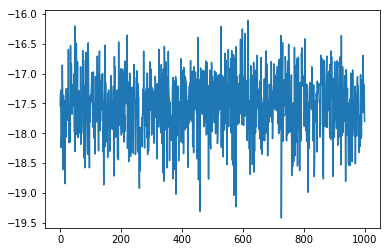

In [76]:
plt.plot(np.arange(len(arr)), arr)
plt.show()


In [52]:
CUser = []
Cirest = []
Cjrest = []
iterations = 100000

In [20]:
import math
def vlen(t):
    su = 0
    for i in t:
        su += i*i
    return su

In [53]:
def loss(CUser,Cirest,Cjrest):
    su = 0
    count = 0
    for user in CUser:
#         print(count)
        count +=1
        for irest in Cirest:
            for jrest in Cjrest:
                xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
                su += np.log(sigmoid(xuij))
    for user in CUser:
        su -= Lambda* vlen(Gamma_u[user])
    for rest in Cirest:
        su -= Lambda* vlen(Gamma_r[rest])
    for rest in Cjrest:
        su -= Lambda* vlen(Gamma_r[rest])
    return su

In [51]:
loss_arr = []

for i in range(iterations):
    user = random.choice(Iu.keys())
    CUser.append(user)
    irest = random.choice(Iu[user])
    Cirest.append(irest)
    jrest = random.choice(list(AllRestSet - set(Iu[user])))
    Cjrest.append(jrest)
    xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
    delta_u_temp = Alpha*(logit(xuij)*(Gamma_r[irest]-Gamma_r[jrest]) - Lambda*Gamma_u[user])
    delta_i_temp = Alpha*(logit(xuij)*(Gamma_u[user]) - Lambda*Gamma_r[irest])
    delta_j_temp = Alpha*(logit(xuij)*(-Gamma_u[user]) - Lambda*Gamma_r[jrest])
    
    Gamma_u[user] += delta_u_temp
    Gamma_r[irest] += delta_i_temp
    Gamma_r[jrest] += delta_j_temp
    loss_arr.append(loss(CUser,Cirest,Cjrest))
    #if i%100 == 0:
    print loss_arr[-1]
    

-76.6752013106
-173.26604979
-285.799075542
-406.083142222
-565.913166579
-715.435833545
-957.538119845
-1217.87843237
-1464.29570736
-1751.69931885
-2056.94105513
-2403.32429464
-2749.15996226
-3135.19035353
-3744.93463403
-4323.76122995
-5062.83172024
-5807.78149799
-6509.54950062
-7353.89673825
-8332.85799596
-9408.95777047
-10706.8003198
-11859.4745413
-12886.5644444
-14075.5777925
-15642.4377723
-17366.6526532


KeyboardInterrupt: 

In [54]:
for i in range(iterations):
    user = random.choice(Iu.keys())
    CUser.append(user)
    irest = random.choice(Iu[user])
    Cirest.append(irest)
    jrest = random.choice(list(AllRestSet - set(Iu[user])))
    Cjrest.append(jrest)
    xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
    Gamma_u[user] += Alpha*(logit(xuij)*(Gamma_r[irest]-Gamma_r[jrest]) + Lambda*Gamma_u[user])
    Gamma_r[irest]+= Alpha*(logit(xuij)*(Gamma_u[user]) + Lambda*Gamma_r[irest])
    Gamma_r[jrest]+= Alpha*(logit(xuij)*(-Gamma_u[user]) + Lambda*Gamma_r[jrest])
    print loss(CUser,Cirest,Cjrest)

-113.292344182
-230.826289111
-340.151455046
-463.120536025
-609.22746753
-800.304994014
-1005.77537811
-1307.22705945
-1563.26462555
-1950.47254603
-2342.7315901
-2849.9255071
-3290.83026302
-3812.97022357
-4433.3669641
-5107.34350906
-5816.44273393
-6671.75907431
-7693.79999549
-8895.91236038
-10338.8236528
-11664.6939489
-12977.9945577
-14452.741165
-15785.1839713
-17494.0930155
-19405.8111097
-21180.1367106
-22669.6815744
-25276.0558267
-27856.2816927
-30894.3127765
-33400.3888714
-36143.8160878
-38426.5867493


KeyboardInterrupt: 